# STL-Embedding Acquisition & Sales

In [1]:
import libs.config as config
import libs.hyperparam as hyperparam
import libs.util as util 
import libs.customized_dataset as customized_dataset
import libs.models as models 
import libs.forecasting as forecasting 
import libs.plots as plots 

import os  # for interacting with the operating system
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # for debugging cuda errors
import glob  # for finding files in directories
import warnings 
warnings.filterwarnings('ignore') # for ignoring all warnings
# import argparse  # for parsing command line arguments (for running from the terminal)

import random
import math # for math operations
import time  # for time-related functionalities
import holidays # for checking if a date is a holiday
import matplotlib.pyplot as plt  # for plotting
plt.set_cmap('cividis') # color map for the plots to 'cividis'
## Enable the display of matplotlib plots inline in a Jupyter notebook
%matplotlib inline 
import matplotlib.ticker as ticker # for customizing the plots' tick locations and labels
import numpy as np  # for numerical computations
import pandas as pd  # for data manipulation and analysis
pd.set_option('display.max_columns', None) # to display all columns
from datetime import date, datetime, timedelta  # for working with dates and times

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer  # for scaling data
from tqdm import tqdm  # for creating progress bars

import torch  # for building and training neural networks
from torch.utils.data import Dataset, DataLoader # for loading and managing datasets
import torch.nn as nn  # for building neural networks
import torch.nn.functional as F  # for implementing various activation functions
import torch.optim as optim  # for defining optimizers

# set the device as GPU with index 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
config.get_environ_info(device)

config.py is loaded.
hyperparam.py is loaded.
util.py is loaded.
customized_dataset.py is loaded.
model.py is loaded.
forecasting.py is loaded.
plot.py is loaded.

pandas version: 2.0.3
pytorch version: 2.0.0+cu118

Device: cuda:0
CUDA version: 11.8
GPU spec: Tesla T4

Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Random seed: 0 for torch and numpy.

Current working directory: /home/kkim476/dl-cbcv/mtl/main


<Figure size 640x480 with 0 Axes>

### Check NVIDIA GPU

In [2]:
# !nvidia-smi

### Set data path

In [3]:
## Google cluster
# READ_DIR = r"/home/kkim476/dl-cbcv/data/weekly_cohort_data_1000_missing_filled_final"
READ_DIR = r"/home/kkim476/dl-cbcv/data/selected_ten" # toy
WORK_DIR = r"/home/kkim476/dl-cbcv"

### Set prediction target, covariates, and save mode

In [4]:
# set prediction target
PREDICTION_GOAL = 'acquisition' 
TARGET_TASK = config.get_target_variable_name(PREDICTION_GOAL)

### set covariate features
USE_EMBEDDING = True
COHORT_EMBEDDING = False
DUMMY_VAR = False # entity embedding, rather than one hot encoding

### folder path for saving results
SAVE_MODE = False
SAVE_DIR = f'{WORK_DIR}/results/stl_embedding_{PREDICTION_GOAL}'
SAVE_MODEL, SAVE_EPOCH, SAVE_PLOT, SAVE_PREDICT, SAVE_ACTUAL = config.create_save_folders(SAVE_MODE, SAVE_DIR)

## Data Preparation

### Load data

In [5]:
## this file is cohort-week level aggregated panel data after ETL of raw earnest transaction DB
raw_df, MERCHANT_NAMES_EMB_INT = util.read_files_generate_behaviorfeatures_get_embed_dict(
    READ_DIR, hyperparam.TRAIN_START, hyperparam.TEST_START, hyperparam.TEST_END,
    group_identifier='acq_week', time_identifier='week',
    acquisition_identifier='N_week_cohort',
    order_identifier = 'orders',
    spend_identifier = 'spend')

FREQ, week_start = util.get_week_start(raw_df, hyperparam.TRAIN_START, hyperparam.TEST_START, hyperparam.TEST_END) 

NOTE: 1000_jam_city_inc_jam_city_inc censored period is empty thus dropped
Number of companies: 11
week start day is 6, w-SUN, Sunday
observed (train start to test end) period (weeks) 118
unobserved (test start to test end) period (weeks) 47


### Generate Time aggregated Time series data

In [9]:
## sales time series
df_sales = raw_df.groupby(['merchant_name','merchant_emb_int','time']).agg({'spend':'sum'}).reset_index()

## acquisition time series
df_acq = raw_df[['merchant_name','merchant_emb_int','group','cohort_size']].drop_duplicates().sort_values(by='group').reset_index(drop=True)

## merge df_sales and df_acq by time
df_sales_acq = df_sales.merge(df_acq, how='left', left_on=['merchant_name','merchant_emb_int','time'], 
                              right_on=['merchant_name','merchant_emb_int','group'])

### Generate calendar time covariates

In [11]:
df_w_cov, country_holidays = util.generate_calendartime_features(df_sales_acq, FREQ, week_start)
# util.check_holidays(df_padded_w_cov, country_holidays)

312 weeks in our zero padded raw data
49 holiday weeks are identified



In [21]:
## limit data range
df = df_w_cov[(df_w_cov['time']<=hyperparam.TEST_END)]
df = df[df['time']>=hyperparam.TRAIN_START_with_offset].reset_index(drop=True)

## get covariate feature names
COVARIATE_FEATURE_NAMES = list(set(df.columns) - set(['time','group','spend','cohort_size','merchant_name']))
covariate_name_to_index = {name: index for index, name in enumerate(COVARIATE_FEATURE_NAMES)}
df

,merchant_name,merchant_emb_int,time,spend,group,cohort_size,week_int,holidays_1w_ahead,linear_trend,quadratic_trend
0,102_shopify_adjusted_shopify_payments,0,2016-10-23,1.294172e+06,2016-10-23,6197,42,0,0,0
1,102_shopify_adjusted_shopify_payments,0,2016-10-30,1.433357e+06,2016-10-30,7069,43,1,0,0
2,102_shopify_adjusted_shopify_payments,0,2016-11-06,1.513683e+06,2016-11-06,7273,44,0,0,0
3,102_shopify_adjusted_shopify_payments,0,2016-11-13,1.622898e+06,2016-11-13,7692,45,1,0,0
4,102_shopify_adjusted_shopify_payments,0,2016-11-20,2.536436e+06,2016-11-20,10711,46,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1920,381_wayfair_adjusted_wayfair,10,2020-01-26,2.197525e+06,2020-01-26,2103,4,0,0,0
1921,381_wayfair_adjusted_wayfair,10,2020-02-02,2.146659e+06,2020-02-02,2047,5,0,0,0
1922,381_wayfair_adjusted_wayfair,10,2020-02-09,2.318820e+06,2020-02-09,2335,6,1,0,0
1923,381_wayfair_adjusted_wayfair,10,2020-02-16,2.889755e+06,2020-02-16,2727,7,0,0,0


### Split data into Train (: Validation) : Test & Transformed to scaled numpy

In [22]:
main_train_scaler_dict, train_np_scaled_lst, val_np_scaled_lst, train_val_np_scaled_lst, test_np_scaled_dict, \
        covariates_train_np_lst, covariates_val_np_lst, covariates_test_np_dict = \
            util.split_acq_df_to_scaled_np_pooled_ver(df, MERCHANT_NAMES_EMB_INT, TARGET_TASK, COVARIATE_FEATURE_NAMES,
                          hyperparam.TRAIN_START_with_offset, hyperparam.TRAIN_END, 
                          hyperparam.TEST_START, hyperparam.TEST_START_with_offset,
                          hyperparam.VAL_LOSS, hyperparam.VAL_START_with_offset, 
                          hyperparam.VAL_END, verbose=False)

min_val_scaler, max_val_scaler = {},{}
for merchant_idx in MERCHANT_NAMES_EMB_INT.values():
    min_val_scaler[merchant_idx] = torch.tensor(main_train_scaler_dict[merchant_idx].data_min_, dtype=torch.float32).to(device)
    max_val_scaler[merchant_idx] = torch.tensor(main_train_scaler_dict[merchant_idx].data_max_, dtype=torch.float32).to(device)


In [ ]:
# import pickle

# ## save intermediate results

# INTERMEDIATE_DATA_PATH = '/home/kkim476/dl-cbcv/data/intermediate_data'
# if not os.path.exists(INTERMEDIATE_DATA_PATH):
#             os.makedirs(INTERMEDIATE_DATA_PATH)

# with open(f'{INTERMEDIATE_DATA_PATH}/train_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'wb') as f:  # 'wb' stands for write binary
#     pickle.dump((main_train_scaler_dict, train_np_scaled_lst, train_val_np_scaled_lst, covariates_train_np_lst), f)

# with open(f'{INTERMEDIATE_DATA_PATH}/val_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'wb') as f:  # 'wb' stands for write binary
#     pickle.dump((val_np_scaled_lst, covariates_val_np_lst), f)

# with open(f'{INTERMEDIATE_DATA_PATH}/test_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'wb') as f:  # 'wb' stands for write binary
#     pickle.dump((test_np_scaled_dict, covariates_test_np_dict), f)

# df.to_hdf(f'{INTERMEDIATE_DATA_PATH}/df_{len(MERCHANT_NAMES_EMB_IDX)}.h5', key='df', mode='w')



# ## load intermediate results

# df = pd.read_hdf(f'{INTERMEDIATE_DATA_PATH}/df_{len(MERCHANT_NAMES_EMB_IDX)}.h5', 'df')

# with open(f'{INTERMEDIATE_DATA_PATH}/train_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'rb') as f:  # 'rb' stands for read binary
#     main_train_scaler_dict, train_np_scaled_lst, train_val_np_scaled_lst, covariates_train_np_lst = pickle.load(f)
    
# with open(f'{INTERMEDIATE_DATA_PATH}/val_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'rb') as f:  # 'rb' stands for read binary
#     val_np_scaled_lst, covariates_val_np_lst = pickle.load(f)
    
# with open(f'{INTERMEDIATE_DATA_PATH}/test_np_mix_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'rb') as f:  # 'rb' stands for read binary
#     test_np_scaled_dict, covariates_test_np_dict = pickle.load(f)


## Dataset and DataLoader


### Generate train loader and validation loader

In [23]:
from libs.customized_dataset import CrossSectionalTimeSeriesDataset, collate_fn, value_dict_to_np
import multiprocessing

## Create a TimeSeriesDataset instance and initialize DataLoader for each data
train_dataset = CrossSectionalTimeSeriesDataset(train_np_scaled_lst, covariates_train_np_lst, hyperparam.INPUT_CHUNK_LENGTH)

## To be iterated over batches of data during training and validation
train_loader = DataLoader(train_dataset, 
                          batch_size=hyperparam.BATCH_SIZE, # how many samples per batch to load
                          shuffle=True, # have the data reshuffled at every epoch to reduce model overfitting
                          drop_last=False, # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller
                          collate_fn=collate_fn, 
                          pin_memory=True, 
                          num_workers=hyperparam.NUM_WORKERS, # how many subprocesses to use for data loading. (0: loaded in the main process)
                          )
if hyperparam.VAL_LOSS:
    val_dataset = CrossSectionalTimeSeriesDataset(val_np_scaled_lst, covariates_val_np_lst, hyperparam.INPUT_CHUNK_LENGTH) 
    val_loader = DataLoader(val_dataset, batch_size=hyperparam.BATCH_SIZE, shuffle=False, drop_last=False, 
                              collate_fn=collate_fn,
                              )
    
## get the dimension of the target and covariate data
first_sample = next(iter(train_dataset)) # or train_dataset[0]
first_batch = next(iter(train_loader))

## number of targets, number of covariate features
tgt_dim, cov_dim = first_sample["target"].shape[1], first_sample["covariate"].shape[1] # 3 , 60


## Model

If considering attention mask later, modify with this:
- `def forward(self, src, attention_mask):`
- `x = self.transformer(src=src, tgt=tgt, src_key_padding_mask=attention_mask)`

## Training (Estimation)

In [ ]:
## For memory monitoring ==
# !pip install memory_profiler
# %load_ext memory_profiler
# %memit my_function()

In [25]:
from libs.models import STL_Transformer

## initialize model
model = STL_Transformer(
    input_dim=tgt_dim + cov_dim,
    feature_dict=covariate_name_to_index, 
    num_merchant=len(MERCHANT_NAMES_EMB_INT),
).to(device)

## define optimizer and loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparam.LEARNING_RATE)
loss_criterion = torch.nn.MSELoss()

## initialize empty list for losses and early stop
train_losses, valid_losses = [], []
pre_valid_loss, cnt_no_improve = np.inf, 0


In [26]:
for epoch in tqdm(range(hyperparam.N_EPOCHS), desc="training", unit="epoch"):
    train_loss = 0.0 # within each epoch, initialize train loss to 0

    for target_input, cov_input, gt in train_loader:
        optimizer.zero_grad() # reset optimizer gradients to zero
        train_input = torch.cat((target_input,cov_input), dim=-1).to(device)   
        next_value = model(train_input) # forward pass data through the model
        loss = loss_criterion(next_value, gt.to(device)) # calculate and update loss 
        train_loss += loss.item() # accumulate batch loss within each epoch
        loss.backward() # backpropagation
        _ = nn.utils.clip_grad_norm_(model.parameters(), hyperparam.GRADCLIP) # clip gradients to prevent exploding gradients
        optimizer.step() # update parameters based on gradients

    train_losses.append(train_loss/len(train_loader)) # append total train loss for each epoch

    if hyperparam.VAL_LOSS:
        valid_loss = 0.0
        for target_input, cov_input, gt in val_loader:
            valid_input = torch.cat((target_input,cov_input), dim=-1).to(device)
            next_value = model(valid_input)
            loss = loss_criterion(next_value, gt.to(device))
            valid_loss += loss.item()

        valid_losses.append(valid_loss/len(val_loader))
        
        # Early stop evaluate
        if pre_valid_loss - valid_loss  < hyperparam.MINDELTA:
            cnt_no_improve += 1
            if cnt_no_improve > hyperparam.PATIENCE:
                break
        else:
            cnt_no_improve = 0
            
        pre_valid_loss = valid_loss
    
    if epoch % 10 == 0:
        print("train_loss:{:.4f}".format(train_loss))
        print("val loss: {:.4f}".format(valid_loss))

training:   1%|          | 1/100 [00:01<01:45,  1.07s/epoch]

train_loss:5.1926
val loss: 0.1899


training:  11%|█         | 11/100 [00:05<00:39,  2.24epoch/s]

train_loss:0.2412
val loss: 0.0570


training:  21%|██        | 21/100 [00:09<00:36,  2.17epoch/s]

train_loss:0.1510
val loss: 0.0535


training:  31%|███       | 31/100 [00:14<00:31,  2.22epoch/s]

train_loss:0.1099
val loss: 0.0384


training:  41%|████      | 41/100 [00:18<00:25,  2.33epoch/s]

train_loss:0.1332
val loss: 0.0420


training:  51%|█████     | 51/100 [00:23<00:21,  2.32epoch/s]

train_loss:0.0742
val loss: 0.0236


training:  61%|██████    | 61/100 [00:27<00:16,  2.36epoch/s]

train_loss:0.0894
val loss: 0.0306


training:  71%|███████   | 71/100 [00:31<00:12,  2.30epoch/s]

train_loss:0.0633
val loss: 0.0292


training:  81%|████████  | 81/100 [00:35<00:07,  2.41epoch/s]

train_loss:0.1004
val loss: 0.0306


training:  91%|█████████ | 91/100 [00:40<00:03,  2.35epoch/s]

train_loss:0.0545
val loss: 0.0334


training: 100%|██████████| 100/100 [00:43<00:00,  2.28epoch/s]


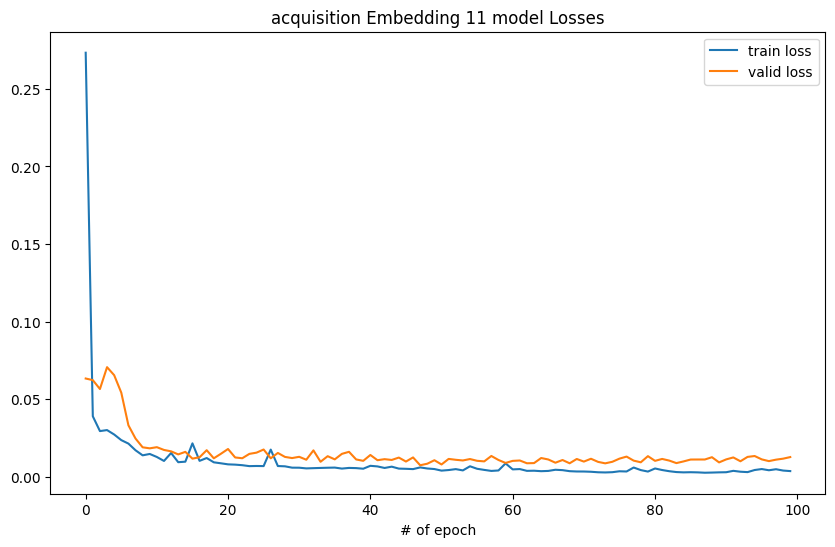

In [27]:
def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.xlabel("# of epoch")
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.title(f"{PREDICTION_GOAL} Embedding {len(MERCHANT_NAMES_EMB_INT)} model Losses")
    plt.legend()
        
plot_losses()

In [28]:
import pickle

if SAVE_MODE:
    # To save the model
    with open(f'{SAVE_MODEL}/{PREDICTION_GOAL}_embedding_{len(MERCHANT_NAMES_EMB_INT)}.pkl', 'wb') as file:
        pickle.dump(model, file)

    # # To load the model
    # with open(f'{SAVE_MODEL}/{PREDICTION_GOAL}_embedding_{len(MERCHANT_NAMES_EMB_IDX)}.pkl', 'rb') as file:
    #     model = pickle.load(file)


## Prediction (Inference)

- rolling forecast origin or walk-forward validation (which means generating predictions one step at a time and conditioning upon the predicted values)
- When you roll over one step at a time, you must ensure that the input sequence fed into the model has the same pattern as during training. If the sequence used for rolling forecast deviates too much from what the model has learned, the forecast can become unreliable. This is particularly true for models that rely heavily on the temporal relationships in the data, like the Transformer.

In [30]:
# Sets the module in training mode
model.eval() 

pred_df_list = []

for key in MERCHANT_NAMES_EMB_INT.keys():
    merchant_name = key
    merchant_emb_idx = MERCHANT_NAMES_EMB_INT[key]
    print(f'{merchant_name}: {merchant_emb_idx} starts!')
    
    subdf = df[df.merchant_name == merchant_name]
    train_val_np_scaled = train_val_np_scaled_lst[merchant_emb_idx]
    train_np_scaled = train_np_scaled_lst[merchant_emb_idx]
    
    # indexing
    t_0 = len(train_val_np_scaled)
    t_n = len(subdf) # len(whole_np_scaled)

    assert len(train_val_np_scaled) == len(subdf[(subdf['time']>=hyperparam.TRAIN_START_with_offset) & (subdf['time'] < hyperparam.TEST_START)]),\
        'Indexing problem befure rolling forecasting'

    ## we only need last sequence of observed data & future known calendar covariates
    # initialize the future target with the last values from the training data
    future_tgt_acc = train_val_np_scaled[-hyperparam.INPUT_CHUNK_LENGTH:] if hyperparam.VAL_LOSS else train_np_scaled[t_0-hyperparam.INPUT_CHUNK_LENGTH:t_0]
    covariates_np = np.array(subdf[COVARIATE_FEATURE_NAMES])

    ## rolling forecast
    for curr_time in range(t_0,t_n):
        # prepare the future input for the model (shifting by one time step)
        future_cov = covariates_np[curr_time-hyperparam.INPUT_CHUNK_LENGTH:curr_time]
        future_tgt = future_tgt_acc[-hyperparam.INPUT_CHUNK_LENGTH:]
        future_tgt_input = torch.from_numpy(np.stack([e for e in future_tgt]).astype(np.float32)).unsqueeze(0)
        future_cov_input = torch.from_numpy(np.stack([e for e in future_cov]).astype(np.float32)).unsqueeze(0)
        future_input = torch.cat((future_tgt_input,future_cov_input), dim=-1).to(device)
        
        # get the predicted next value from the model
        next_value = model(future_input) # gpu

        # add the predicted value to the future target
        future_tgt_acc = np.concatenate((future_tgt_acc, next_value.detach().cpu().numpy()), axis=0)

    # concatenate the predicted values with the actual values
    predicted_hist = np.concatenate((train_val_np_scaled, future_tgt_acc[hyperparam.INPUT_CHUNK_LENGTH:]),axis=0)
    # ground_truth = whole_np_scaled

    # Inverse transform the scaled data
    unscaled_predicted_hist = main_train_scaler_dict[merchant_emb_idx].inverse_transform(predicted_hist.reshape(-1, 1)).flatten()
    # unscaled_ground_truth = train_scaler.inverse_transform(ground_truth.reshape(-1, 1)).flatten()
    unscaled_ground_truth = subdf[TARGET_TASK] ## identical with above
    
    pred_df = pd.DataFrame({'time':subdf.time,
                        'predicted':unscaled_predicted_hist, 
                        'actual':unscaled_ground_truth,
                        'merchant_name':merchant_name})
    
    pred_df_list.append(pred_df)

# Concatenate all dataframes in the list
combined_df = pd.concat(pred_df_list)


102_shopify_adjusted_shopify_payments: 0 starts!
104_planet_fitness_adjusted_planet_fitness: 1 starts!
108_yum_pizza_hut_pizza_hut: 2 starts!
113_grubhub_adjusted_grubhub_seamless: 3 starts!
122_autozone_autozone: 4 starts!
129_geico_geico: 5 starts!
169_robinhood_robinhood: 6 starts!
172_goodwill_goodwill: 7 starts!
177_digit_co_digit_co: 8 starts!
193_instacart_adjusted_instacart_transaction: 9 starts!
381_wayfair_adjusted_wayfair: 10 starts!


In [32]:
combined_df

,time,predicted,actual,merchant_name
0,2016-10-23,6197.000000,6197,102_shopify_adjusted_shopify_payments
1,2016-10-30,7069.000000,7069,102_shopify_adjusted_shopify_payments
2,2016-11-06,7273.000000,7273,102_shopify_adjusted_shopify_payments
3,2016-11-13,7692.000000,7692,102_shopify_adjusted_shopify_payments
4,2016-11-20,10711.000000,10711,102_shopify_adjusted_shopify_payments
...,...,...,...,...
1920,2020-01-26,1943.903788,2103,381_wayfair_adjusted_wayfair
1921,2020-02-02,1929.692390,2047,381_wayfair_adjusted_wayfair
1922,2020-02-09,1943.236884,2335,381_wayfair_adjusted_wayfair
1923,2020-02-16,2297.339865,2727,381_wayfair_adjusted_wayfair


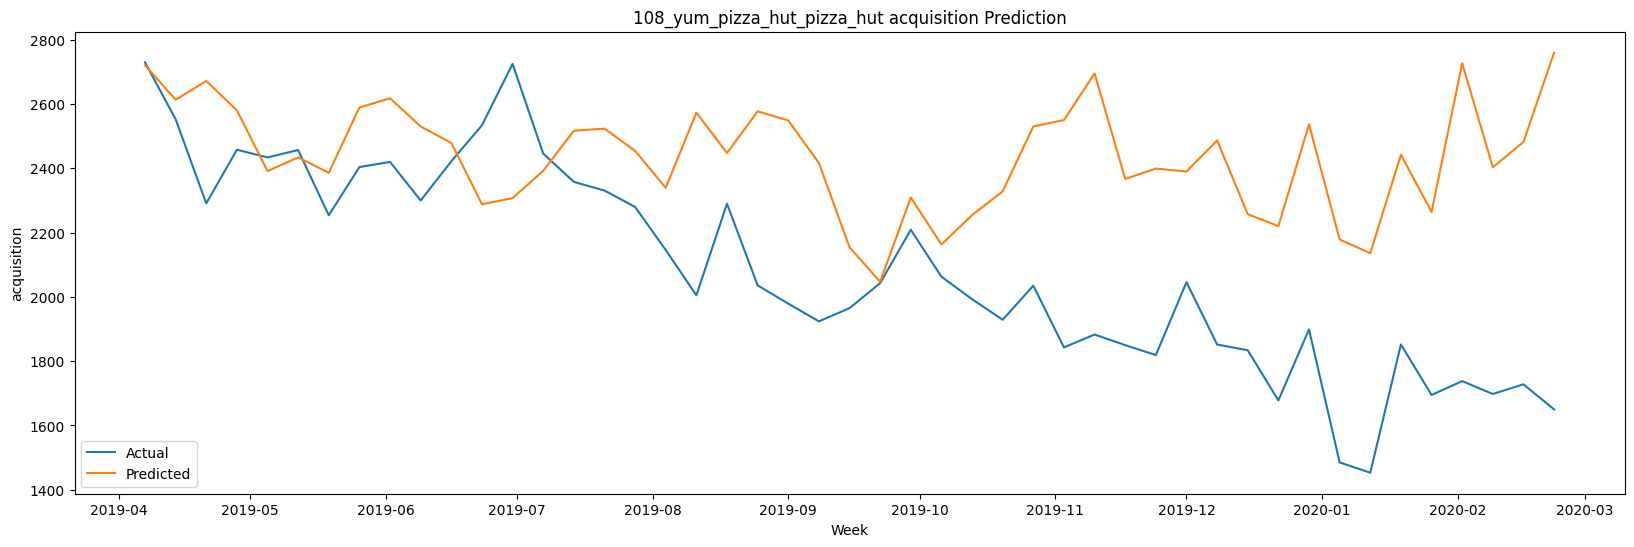

In [38]:
def plot_test_period(MERCHANT_NAME):
    pred_df = combined_df[combined_df['merchant_name']==MERCHANT_NAME]
    # Plot the unscaled predicted history and actual values
    plt.figure(figsize=(20, 6))
    plt.title(f"{MERCHANT_NAME} {PREDICTION_GOAL} Prediction")
    plt.xlabel('Week')
    plt.ylabel(PREDICTION_GOAL)
    # plt.xticks(np.arange(0, len(pred_df), 4), rotation=45) # x-axis label is every 4th week
        
    plt.plot(pred_df[pred_df['time']>=hyperparam.TEST_START].time, pred_df[pred_df['time']>=hyperparam.TEST_START].actual, label="Actual")
    plt.plot(pred_df[pred_df['time']>=hyperparam.TEST_START].time, pred_df[pred_df['time']>=hyperparam.TEST_START].predicted, label="Predicted")
    plt.legend()

plot_test_period(list(MERCHANT_NAMES_EMB_INT.keys())[2])

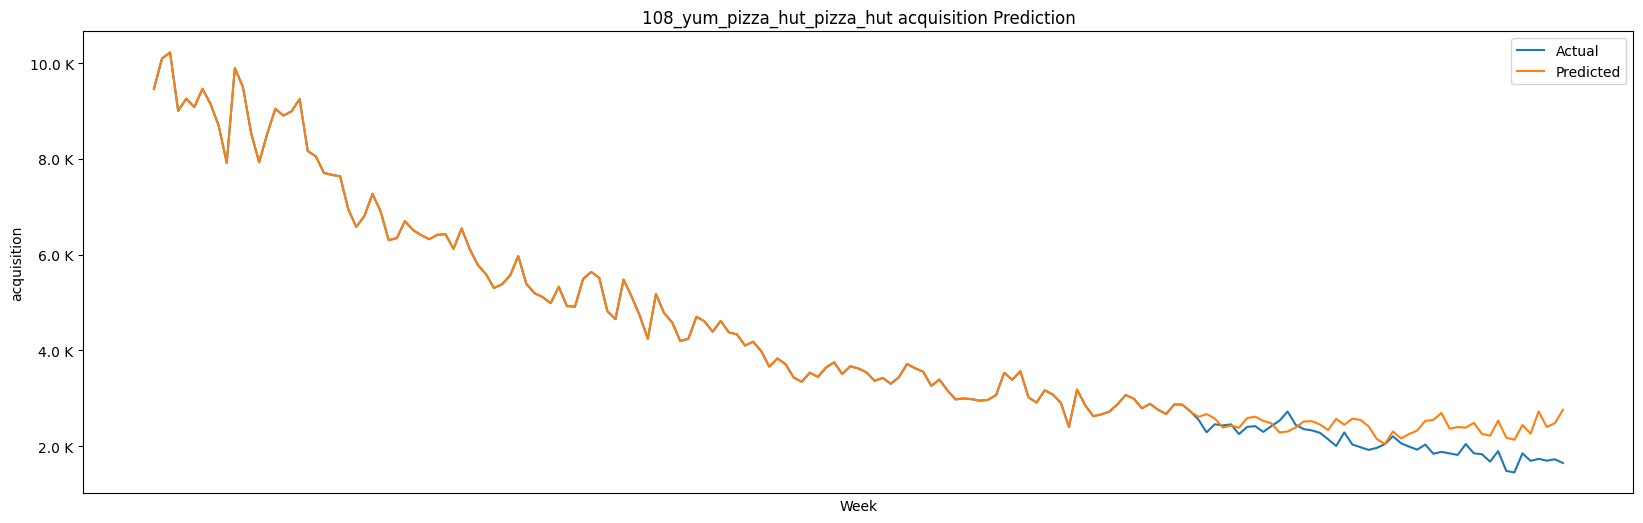

In [39]:
def plot_whole_period(MERCHANT_NAME):
    pred_df = combined_df[combined_df['merchant_name']==MERCHANT_NAME]
    # Plot the unscaled predicted history and actual values
    plt.figure(figsize=(20, 6))
    plt.title(f"{MERCHANT_NAME} {PREDICTION_GOAL} Prediction")
    plt.xlabel('Week')
    plt.ylabel(PREDICTION_GOAL)
    plt.xticks(np.arange(0, len(pred_df), 4), rotation=45) # x-axis label is every 4th week

    unit=1
    if pred_df.actual.mean() > 1000:
        def thousands(x, pos):
            return '%1.1f K' % (x)  # Multiply by 1e-3 to convert from units to thousands
        formatter = ticker.FuncFormatter(thousands)
        unit=1e3
        plt.gca().yaxis.set_major_formatter(formatter)
                
    plt.plot(pred_df.time, pred_df.actual/unit, label="Actual")
    plt.plot(pred_df.time, pred_df.predicted/unit, label="Predicted")
    plt.legend()

plot_whole_period(list(MERCHANT_NAMES_EMB_INT.keys())[2])

In [41]:
from libs.plots import save_plots_to_pdf

if SAVE_MODE:    
    # Saving traininig and validation losses
    save_plots_to_pdf([
        (plot_losses,{}),
        ], f'{SAVE_EPOCH}/train_loss.pdf')
        
    for key in MERCHANT_NAMES_EMB_INT.keys():
        MERCHANT_NAME = key    
        pred_df = combined_df[combined_df.merchant_name == MERCHANT_NAME]

        # Saving plots to PDF
        save_plots_to_pdf([
        (plot_test_period,{'MERCHANT_NAME':MERCHANT_NAME}),
        (plot_whole_period,{'MERCHANT_NAME':MERCHANT_NAME}),
            ], f'{SAVE_PLOT}/{MERCHANT_NAME}.pdf')
        
        pred_df['merchant_index'] = raw_df['merchant_index'][1]
        pred_df['parent_merchant'] = raw_df['parent_merchant'][1]
        pred_df['merchant'] = raw_df['merchant'][1]

        # Saving csv files
        pred_df.to_csv(f'{SAVE_PREDICT}/{MERCHANT_NAME}_pred.csv', index=False)
